In [1]:
import os
import json 
import argparse
import numpy as np
import math
import pickle
import datetime
import time
import logging
import itertools

You can specify an URL to an image:

In [2]:
url = 'https://cdn.topofart.com/images/artists/John_Singer_Sargent/paintings/sargent029.jpg'
import urllib.request
urllib.request.urlretrieve(url, "input_img.jpg")
imgpath = os.path.abspath("input_img.jpg")

Or specify an image from the styletransfer art dataset:

In [ ]:
imgpath = '/home/althausc/nfs/data/coco_17_medium/val2017_styletransfer/000000000785_050351.jpg'

Show the loaded image:

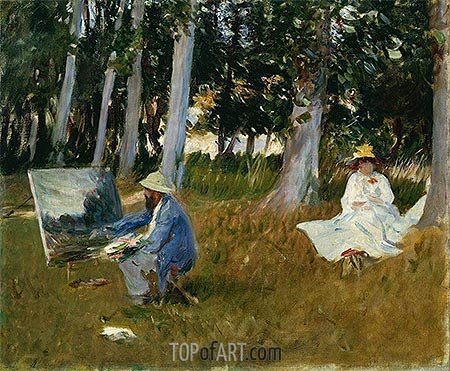

In [3]:
from IPython.display import Image, display
display(Image(filename=imgpath))

Infer the scene graph from the image & Visualize the result:

In [4]:
from predict_search_modules import predict_scenegraph, visualize_scenegraph

annpath = predict_scenegraph(imgpath)

imgs = visualize_scenegraph(annpath)
display(Image(filename=imgs[0]))


/home/althausc/master_thesis_impl/scripts/branchgraphs/input_img.jpg
SCENE GRAPH PREDICTION:


ValueError: max() arg is an empty sequence

Filter out best predictions & Transform into Graph2Vec input format:

In [ ]:
from predict_search_modules import transform_into_g2vformat

graphfile = transform_into_g2vformat(annpath)

Search best matching image (respectively graph) from previous trained model:

In [ ]:
from predict_search_modules import search_topk
k = 10
topk = search_topk(graphfile, k)